In [17]:
import os
import torch
from glob import glob
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import kagglehub

## Configuration

In [18]:
class Config:
    model_name = "swin_tiny_patch4_window7_224"
    img_size = 224
    batch_size = 32
    lr = 1e-4
    epochs = 50
    patience = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_split = 0.70
    val_split = 0.15
    test_split = 0.15
    experiments = {
        "with_sampler": True,
        "without_sampler": False,
    }

    save_dir = "checkpoints"
    os.makedirs(save_dir, exist_ok=True)

CFG = Config()

## Transform & Dataset Class

In [19]:
train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class ChestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [20]:
# Google Colab training
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
DATA_DIR = f"{path}/chest_xray/"

# Local training
# DATA_DIR = "Dataset/chest_xray/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

normal_imgs = glob(TEST_DIR + "/NORMAL/*.jpeg") + glob(TRAIN_DIR + "/NORMAL/*.jpeg") + glob(VAL_DIR + "/NORMAL/*.jpeg")
pneumonia_imgs = glob(TEST_DIR + "/PNEUMONIA/*.jpeg") + glob(TRAIN_DIR + "/PNEUMONIA/*.jpeg") + glob(VAL_DIR + "/PNEUMONIA/*.jpeg")

all_images = normal_imgs + pneumonia_imgs
labels = [0]*len(normal_imgs) + [1]*len(pneumonia_imgs)

print(f"Total normal images: {len(normal_imgs)}")
print(f"Total pneumonia images: {len(pneumonia_imgs)}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Total normal images: 1583
Total pneumonia images: 4273


In [21]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_images, labels, test_size=CFG.test_split, stratify=labels, random_state=42
)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs, train_labels, test_size=CFG.val_split/(1-CFG.val_split), stratify=train_labels, random_state=42
)

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 4098
Val: 879
Test: 879


## DataLoaders with WeightedRandomSampler

In [22]:
# Build loaders with or without a weighted sampler to compare class balancing strategies
def build_loaders(use_sampler: bool):
    class_counts = [train_labels.count(0), train_labels.count(1)]  # Normal, Pneumonia
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(
        sample_weights, num_samples=len(sample_weights), replacement=True
    ) if use_sampler else None

    train_data = ChestDataset(train_imgs, train_labels, transform=train_tf)
    val_data   = ChestDataset(val_imgs, val_labels, transform=test_tf)
    test_data  = ChestDataset(test_imgs, test_labels, transform=test_tf)

    train_loader = DataLoader(
        train_data, batch_size=CFG.batch_size, sampler=sampler, shuffle=not use_sampler
    )
    val_loader   = DataLoader(val_data, batch_size=CFG.batch_size, shuffle=False)
    test_loader  = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, class_weights

## Swin Transformer Model

In [23]:
def build_model(class_weights):
    model = timm.create_model(
        CFG.model_name,
        pretrained=True,
        num_classes=2
    ).to(CFG.device)

    # Freeze all layers
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze only the final classification head
    if hasattr(model, 'head') and model.head is not None:
        for p in model.head.parameters():
            p.requires_grad = True

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(CFG.device))
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.lr, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5
    )

    return model, criterion, optimizer, scheduler

## Training Model

In [24]:
best_val_loss = None
patience_counter = None
best_model_path = None

history = None

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False, total=len(loader)):
        imgs = imgs.to(CFG.device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False, total=len(loader)):
            imgs = imgs.to(CFG.device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)


def run_experiment(label: str, use_sampler: bool):
    train_loader, val_loader, _, class_weights = build_loaders(use_sampler)
    model, criterion, optimizer, scheduler = build_model(class_weights)

    best_val_loss = np.inf
    patience_counter = 0
    best_model_path = f"{CFG.save_dir}/{label}_best.pt"

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc" : []
    }

    for epoch in range(CFG.epochs):
        print(f"\n[{label}] Epoch {epoch+1}/{CFG.epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}  |  Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  |  Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(">>> Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= CFG.patience:
                print(">>> Early stopping triggered!")
                break

    return history, best_model_path


histories = {}
best_paths = {}

for name, use_sampler in CFG.experiments.items():
    print(f"\n=== Running {name} (use_sampler={use_sampler}) ===")
    history, best_path = run_experiment(name, use_sampler)
    histories[name] = history
    best_paths[name] = best_path


=== Running with_sampler (use_sampler=True) ===

[with_sampler] Epoch 1/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.4583  |  Acc: 0.6135
Val   Loss: 0.4791  |  Acc: 0.6871
>>> Saved best model!

[with_sampler] Epoch 2/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3021  |  Acc: 0.8226
Val   Loss: 0.3630  |  Acc: 0.8009
>>> Saved best model!

[with_sampler] Epoch 3/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2452  |  Acc: 0.8729
Val   Loss: 0.3142  |  Acc: 0.8271
>>> Saved best model!

[with_sampler] Epoch 4/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2279  |  Acc: 0.8812
Val   Loss: 0.2707  |  Acc: 0.8635
>>> Saved best model!

[with_sampler] Epoch 5/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2087  |  Acc: 0.9026
Val   Loss: 0.2662  |  Acc: 0.8612
>>> Saved best model!

[with_sampler] Epoch 6/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2051  |  Acc: 0.8973
Val   Loss: 0.2441  |  Acc: 0.8714
>>> Saved best model!

[with_sampler] Epoch 7/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1911  |  Acc: 0.9073
Val   Loss: 0.2387  |  Acc: 0.8783
>>> Saved best model!

[with_sampler] Epoch 8/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1941  |  Acc: 0.9058
Val   Loss: 0.2445  |  Acc: 0.8749

[with_sampler] Epoch 9/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1736  |  Acc: 0.9170
Val   Loss: 0.2544  |  Acc: 0.8669

[with_sampler] Epoch 10/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1650  |  Acc: 0.9197
Val   Loss: 0.2327  |  Acc: 0.8794
>>> Saved best model!

[with_sampler] Epoch 11/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1676  |  Acc: 0.9202
Val   Loss: 0.2441  |  Acc: 0.8714

[with_sampler] Epoch 12/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1660  |  Acc: 0.9204
Val   Loss: 0.2289  |  Acc: 0.8817
>>> Saved best model!

[with_sampler] Epoch 13/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1544  |  Acc: 0.9253
Val   Loss: 0.2257  |  Acc: 0.8805
>>> Saved best model!

[with_sampler] Epoch 14/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1526  |  Acc: 0.9263
Val   Loss: 0.2291  |  Acc: 0.8828

[with_sampler] Epoch 15/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1454  |  Acc: 0.9297
Val   Loss: 0.2293  |  Acc: 0.8851

[with_sampler] Epoch 16/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1651  |  Acc: 0.9214
Val   Loss: 0.2121  |  Acc: 0.8874
>>> Saved best model!

[with_sampler] Epoch 17/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1645  |  Acc: 0.9229
Val   Loss: 0.2139  |  Acc: 0.8896

[with_sampler] Epoch 18/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1378  |  Acc: 0.9334
Val   Loss: 0.2344  |  Acc: 0.8805

[with_sampler] Epoch 19/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1527  |  Acc: 0.9270
Val   Loss: 0.2117  |  Acc: 0.8919
>>> Saved best model!

[with_sampler] Epoch 20/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1386  |  Acc: 0.9312
Val   Loss: 0.2124  |  Acc: 0.8908

[with_sampler] Epoch 21/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1414  |  Acc: 0.9348
Val   Loss: 0.2040  |  Acc: 0.8976
>>> Saved best model!

[with_sampler] Epoch 22/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1423  |  Acc: 0.9285
Val   Loss: 0.2247  |  Acc: 0.8840

[with_sampler] Epoch 23/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1491  |  Acc: 0.9283
Val   Loss: 0.1970  |  Acc: 0.8999
>>> Saved best model!

[with_sampler] Epoch 24/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1425  |  Acc: 0.9331
Val   Loss: 0.2243  |  Acc: 0.8851

[with_sampler] Epoch 25/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1368  |  Acc: 0.9292
Val   Loss: 0.1928  |  Acc: 0.8999
>>> Saved best model!

[with_sampler] Epoch 26/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1325  |  Acc: 0.9366
Val   Loss: 0.2052  |  Acc: 0.8965

[with_sampler] Epoch 27/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1353  |  Acc: 0.9297
Val   Loss: 0.2112  |  Acc: 0.8908

[with_sampler] Epoch 28/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1345  |  Acc: 0.9348
Val   Loss: 0.2019  |  Acc: 0.8987

[with_sampler] Epoch 29/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1428  |  Acc: 0.9327
Val   Loss: 0.2056  |  Acc: 0.8965

[with_sampler] Epoch 30/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1435  |  Acc: 0.9449
Val   Loss: 0.2080  |  Acc: 0.8965
>>> Early stopping triggered!

=== Running without_sampler (use_sampler=False) ===

[without_sampler] Epoch 1/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.5349  |  Acc: 0.7511
Val   Loss: 0.4105  |  Acc: 0.8771
>>> Saved best model!

[without_sampler] Epoch 2/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3661  |  Acc: 0.8755
Val   Loss: 0.3150  |  Acc: 0.8737
>>> Saved best model!

[without_sampler] Epoch 3/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3024  |  Acc: 0.8909
Val   Loss: 0.2706  |  Acc: 0.8851
>>> Saved best model!

[without_sampler] Epoch 4/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2690  |  Acc: 0.9029
Val   Loss: 0.2423  |  Acc: 0.8976
>>> Saved best model!

[without_sampler] Epoch 5/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2426  |  Acc: 0.9151
Val   Loss: 0.2239  |  Acc: 0.9078
>>> Saved best model!

[without_sampler] Epoch 6/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2299  |  Acc: 0.9165
Val   Loss: 0.2166  |  Acc: 0.9033
>>> Saved best model!

[without_sampler] Epoch 7/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2238  |  Acc: 0.9165
Val   Loss: 0.2063  |  Acc: 0.9056
>>> Saved best model!

[without_sampler] Epoch 8/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2111  |  Acc: 0.9246
Val   Loss: 0.1995  |  Acc: 0.9113
>>> Saved best model!

[without_sampler] Epoch 9/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2027  |  Acc: 0.9275
Val   Loss: 0.1947  |  Acc: 0.9113
>>> Saved best model!

[without_sampler] Epoch 10/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1975  |  Acc: 0.9265
Val   Loss: 0.1891  |  Acc: 0.9113
>>> Saved best model!

[without_sampler] Epoch 11/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1894  |  Acc: 0.9331
Val   Loss: 0.1885  |  Acc: 0.9101
>>> Saved best model!

[without_sampler] Epoch 12/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1896  |  Acc: 0.9295
Val   Loss: 0.1839  |  Acc: 0.9147
>>> Saved best model!

[without_sampler] Epoch 13/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1876  |  Acc: 0.9307
Val   Loss: 0.1794  |  Acc: 0.9261
>>> Saved best model!

[without_sampler] Epoch 14/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1855  |  Acc: 0.9268
Val   Loss: 0.1772  |  Acc: 0.9261
>>> Saved best model!

[without_sampler] Epoch 15/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1651  |  Acc: 0.9417
Val   Loss: 0.1779  |  Acc: 0.9124

[without_sampler] Epoch 16/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1689  |  Acc: 0.9390
Val   Loss: 0.1761  |  Acc: 0.9192
>>> Saved best model!

[without_sampler] Epoch 17/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1708  |  Acc: 0.9368
Val   Loss: 0.1752  |  Acc: 0.9204
>>> Saved best model!

[without_sampler] Epoch 18/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1746  |  Acc: 0.9363
Val   Loss: 0.1798  |  Acc: 0.9101

[without_sampler] Epoch 19/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1745  |  Acc: 0.9341
Val   Loss: 0.1727  |  Acc: 0.9181
>>> Saved best model!

[without_sampler] Epoch 20/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1671  |  Acc: 0.9361
Val   Loss: 0.1709  |  Acc: 0.9238
>>> Saved best model!

[without_sampler] Epoch 21/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1738  |  Acc: 0.9361
Val   Loss: 0.1695  |  Acc: 0.9272
>>> Saved best model!

[without_sampler] Epoch 22/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1611  |  Acc: 0.9468
Val   Loss: 0.1692  |  Acc: 0.9249
>>> Saved best model!

[without_sampler] Epoch 23/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1608  |  Acc: 0.9407
Val   Loss: 0.1659  |  Acc: 0.9397
>>> Saved best model!

[without_sampler] Epoch 24/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1684  |  Acc: 0.9407
Val   Loss: 0.1704  |  Acc: 0.9226

[without_sampler] Epoch 25/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1594  |  Acc: 0.9388
Val   Loss: 0.1712  |  Acc: 0.9204

[without_sampler] Epoch 26/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1673  |  Acc: 0.9373
Val   Loss: 0.1692  |  Acc: 0.9272

[without_sampler] Epoch 27/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1673  |  Acc: 0.9380
Val   Loss: 0.1671  |  Acc: 0.9306

[without_sampler] Epoch 28/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1636  |  Acc: 0.9392
Val   Loss: 0.1657  |  Acc: 0.9340
>>> Saved best model!

[without_sampler] Epoch 29/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1624  |  Acc: 0.9388
Val   Loss: 0.1640  |  Acc: 0.9363
>>> Saved best model!

[without_sampler] Epoch 30/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1579  |  Acc: 0.9414
Val   Loss: 0.1651  |  Acc: 0.9306

[without_sampler] Epoch 31/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1568  |  Acc: 0.9468
Val   Loss: 0.1634  |  Acc: 0.9363
>>> Saved best model!

[without_sampler] Epoch 32/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1568  |  Acc: 0.9439
Val   Loss: 0.1625  |  Acc: 0.9352
>>> Saved best model!

[without_sampler] Epoch 33/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1542  |  Acc: 0.9458
Val   Loss: 0.1635  |  Acc: 0.9352

[without_sampler] Epoch 34/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1559  |  Acc: 0.9434
Val   Loss: 0.1636  |  Acc: 0.9340

[without_sampler] Epoch 35/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1649  |  Acc: 0.9431
Val   Loss: 0.1626  |  Acc: 0.9352

[without_sampler] Epoch 36/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1613  |  Acc: 0.9392
Val   Loss: 0.1631  |  Acc: 0.9352

[without_sampler] Epoch 37/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1586  |  Acc: 0.9424
Val   Loss: 0.1644  |  Acc: 0.9340
>>> Early stopping triggered!


## Plot Loss & Training Curves

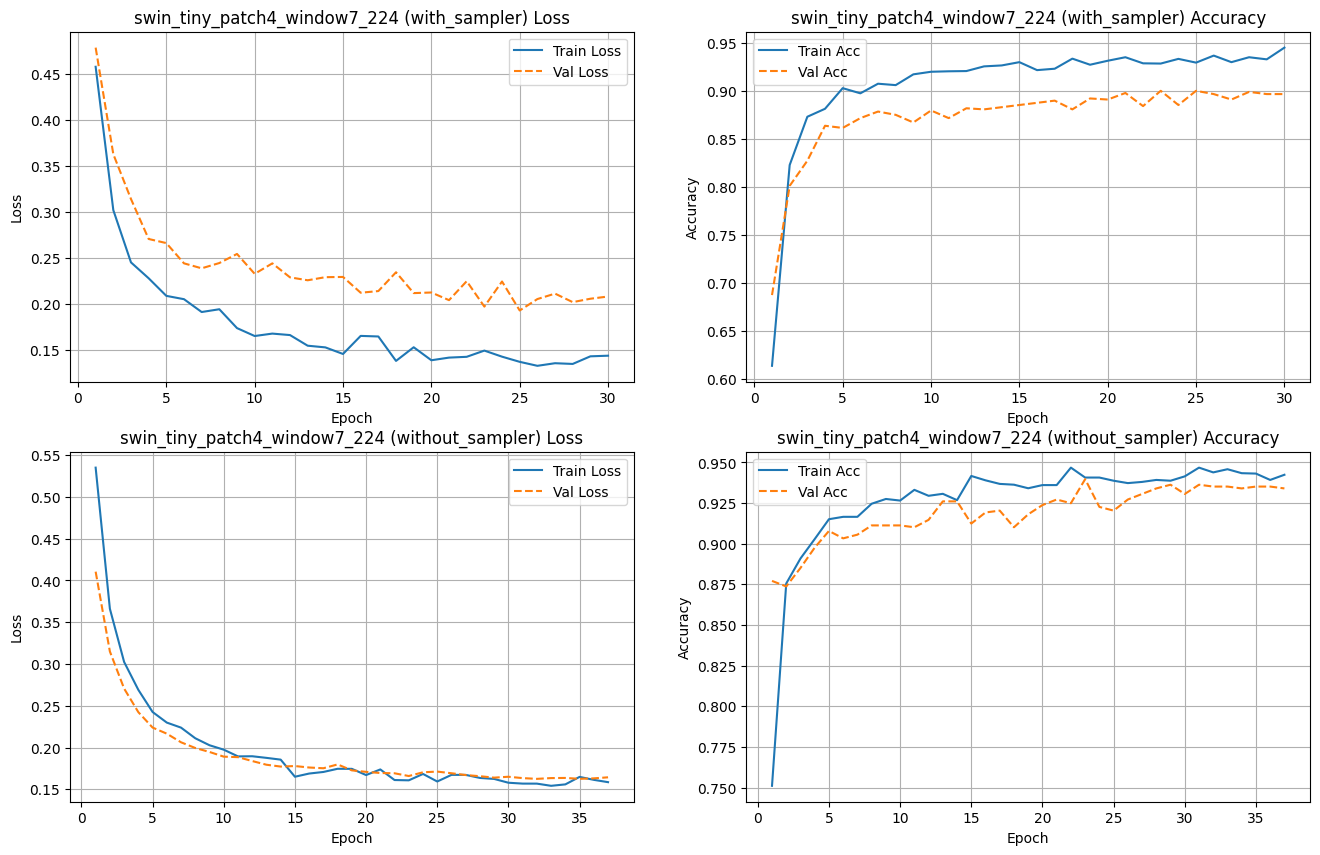

In [25]:
plt.figure(figsize=(16, 10))

# with_sampler loss/acc
if "with_sampler" in histories:
    hs = histories["with_sampler"]
    epochs_range = range(1, len(hs["train_loss"]) + 1)

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, hs["train_loss"], label="Train Loss")
    plt.plot(epochs_range, hs["val_loss"], linestyle="--", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{CFG.model_name} (with_sampler) Loss")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, hs["train_acc"], label="Train Acc")
    plt.plot(epochs_range, hs["val_acc"], linestyle="--", label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{CFG.model_name} (with_sampler) Accuracy")
    plt.legend()
    plt.grid()

# without_sampler loss/acc
if "without_sampler" in histories:
    hs = histories["without_sampler"]
    epochs_range = range(1, len(hs["train_loss"]) + 1)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, hs["train_loss"], label="Train Loss")
    plt.plot(epochs_range, hs["val_loss"], linestyle="--", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{CFG.model_name} (without_sampler) Loss")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, hs["train_acc"], label="Train Acc")
    plt.plot(epochs_range, hs["val_acc"], linestyle="--", label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{CFG.model_name} (without_sampler) Accuracy")
    plt.legend()
    plt.grid()

plt.show()

## Model Evaluation

In [26]:
def evaluate_model(best_path: str, use_sampler: bool):
    _, _, test_loader, class_weights = build_loaders(use_sampler)
    model, _, _, _ = build_model(class_weights)
    model.load_state_dict(torch.load(best_path, map_location=CFG.device))
    model.to(CFG.device)
    model.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(CFG.device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            probs_batch = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs_batch)

    return {"preds": all_preds, "labels": all_labels, "probs": all_probs}


eval_results = {}
for name, use_sampler in CFG.experiments.items():
    print(f"Evaluating {name} (use_sampler={use_sampler})")
    eval_results[name] = evaluate_model(best_paths[name], use_sampler)
    print(f"{name}: collected {len(eval_results[name]['labels'])} test samples")

Evaluating with_sampler (use_sampler=True)
with_sampler: collected 879 test samples
Evaluating without_sampler (use_sampler=False)
without_sampler: collected 879 test samples


## Confusion Matrix + Classification Report + ROC-AUC

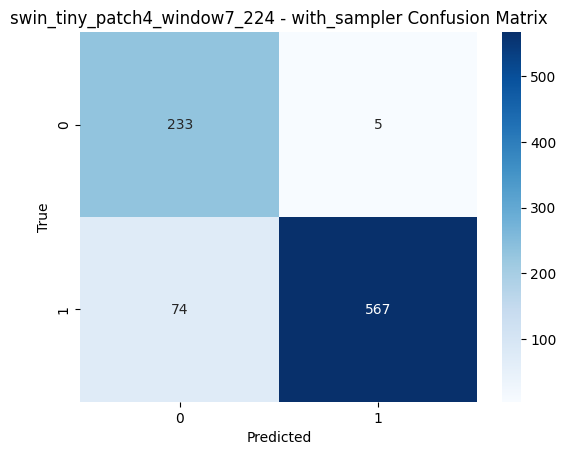

swin_tiny_patch4_window7_224 - with_sampler classification report
              precision    recall  f1-score   support

      Normal       0.76      0.98      0.86       238
   Pneumonia       0.99      0.88      0.93       641

    accuracy                           0.91       879
   macro avg       0.88      0.93      0.89       879
weighted avg       0.93      0.91      0.91       879



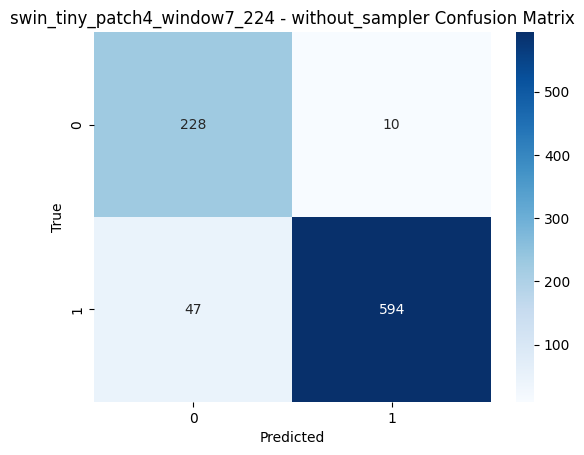

swin_tiny_patch4_window7_224 - without_sampler classification report
              precision    recall  f1-score   support

      Normal       0.83      0.96      0.89       238
   Pneumonia       0.98      0.93      0.95       641

    accuracy                           0.94       879
   macro avg       0.91      0.94      0.92       879
weighted avg       0.94      0.94      0.94       879



In [27]:
for name, result in eval_results.items():
    cm = confusion_matrix(result["labels"], result["preds"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{CFG.model_name} - {name} Confusion Matrix")
    plt.show()

    print(f"{CFG.model_name} - {name} classification report")
    print(classification_report(result["labels"], result["preds"], target_names=["Normal", "Pneumonia"]))

swin_tiny_patch4_window7_224 - with_sampler ROC AUC Score: 0.9862


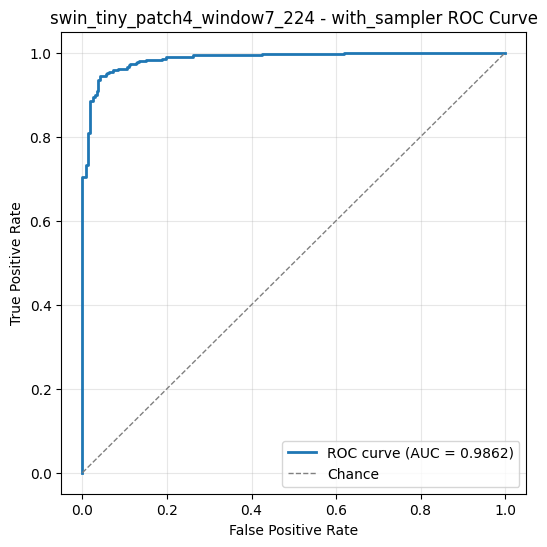

swin_tiny_patch4_window7_224 - without_sampler ROC AUC Score: 0.9867


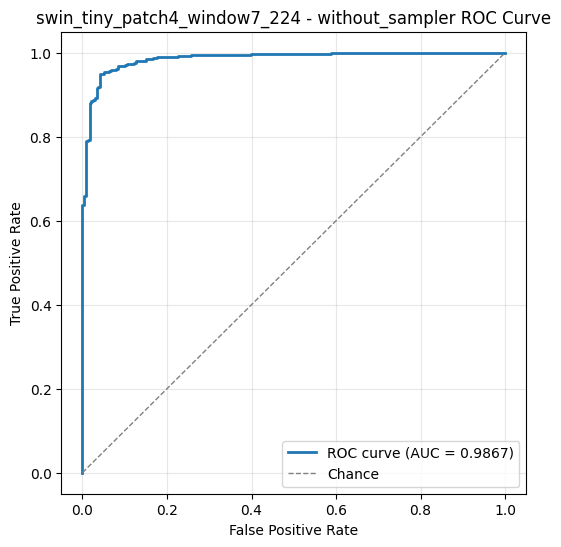

In [28]:
for name, result in eval_results.items():
    fpr, tpr, _ = roc_curve(result["labels"], result["probs"], pos_label=1)
    auc_score = roc_auc_score(result["labels"], result["probs"])

    print(f"{CFG.model_name} - {name} ROC AUC Score: {auc_score:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="C0", lw=2, label=f"ROC curve (AUC = {auc_score:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=1, linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{CFG.model_name} - {name} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()